# Clustering with Quantum Annealing

Clustering is a type of unsupervised learning task where the goal is to partition a set of data points into groups or clusters, such that data points within the same cluster are more similar to each other than to those in other clusters.

There are various clustering methods such as K-Means, K-Medoids, DBSCAN. Each one of them, is a specific clustering problem with a different objective.

For example, K-Means aims at finding $k$ clusters that minimize the square distance from each point in $X$ to its cluster's centroid.



## A possible K-Means formulation


The $k$-Means problem formulation is the following one:
$$
    obj = \arg\min_{C} \sum\limits_{i = 1}^{K} \sum\limits_{x \in C_i}{|| x - \mu_i ||^2}
$$
where $\mu_i$ represents the center of the cluster $C_i$and is defined as
$$
    \mu_i = \frac{1}{|C_i|} \sum\limits_{x \in C_i} x
$$
and $C=\{C_1,C_2,...,C_k\}$ is the set of $k$ clusters.

To solve the $k$-Means problem (which is a NP-HARD problem) the Lloyd's algorithm can be used. It is a well known heuristic in which we iteratively select a set of centers $\{c_1,...,c_k\}$ trying to improve the current value of the objective function.

A possible QUBO formulation for the $k$-Means problem can be derived as follows.

We define a binary variable $z_i^k$ such that:

\begin{equation}
z_i^k=
    \begin{cases}
        1 & \text{if point }  x_i \in C_i\\
        0 & \text{otherwise }
    \end{cases}
\end{equation}






Then, since each point $x_i \in X$ must belong to a single cluster $C_i$ at the end, we must add the following constraints:
$$
\sum\limits_{k=1}^K z_i^k =1 \text{ }∀ i
$$


Then we want to have that closer points will be grouped together. This can be achieved as follows.
$$
obj= \sum\limits_{k=1}^K \sum\limits_{i \neq j}z_i^k D_{i,j} z_j^k
$$

where $D_{i,j}$ is the distance between the points $x_i$ and $x_j$.

Since our final aim is to minimize our objective function $obj$, we can interpret it as trying to minimize the total distance between points within the same cluster, encouraging the clustering algorithm to group similar points together. In fact, if 2 variables $z_i^k$ and $z_j^k$ are set to 1, this means that we chose both points $x_i$ and $x_j$ to be part of the cluster $C_k$. However, since we are minimizing the objective function, in this case if their distance is **high** it is likely that they will not be selected as part of $C_k$ but rather other points that are more close between each other will be chosen.

Now the final formulation involves putting together the constraints and our objective function, thus obtaining after a transformation of the constraints:

$$
obj'=α \sum\limits_{i=1}^{|X|} (\sum\limits_{k=1}^K z_i^k -1)^2 + \sum\limits_{k=1}^K \sum\limits_{i \neq j}z_i^k D_{i,j} z_j^k
$$

where $α$ represents how strong the constraints should be. It is an hyperparameter that must be tuned according to our problem.

### The issues
We have 2 main issues: one concerning $k$-Means and one its formulation.



1.   **$k$-Means**: $k$-Means does not cope well with outliers. In fact, it is sensitive to outliers since it relies on mean-based centroids and the squared Euclidean distance metric. Outliers, which are data points that deviate significantly from the rest of the data, can have a disproportionate impact on the computation of cluster centroids and can distort the clustering result. Furthermore, $k$-Means works well with spherical clusters but sometimes points can be clustered in different shapes.
2.   **Formulation**: our formulation requires a number of variables that depends both on the number of points that we want to cluster but also on the number of final clusters $K$. This is a big issue since having a high number of variables can negatively impact (a lot) the results. In fact, if we want to cluster 100 points in 5 clusters, we need to create 100*5 different variables. However, the maximum number of variables that quantum annealers can handle is in the order of 100-150 variables. This formulation limits the size of problems we can solve.



To solve this issue, we can rely on another clustering method which is $k$-Medoids. In fact, as we will see in the next section, $k$-Medoids is more resistant to outliers and it is possible to find a formulation which involves just a number of variables that is equal to the number of points we want to cluster, thus being independent on the number of clusters $K$!

# Qk-medoids: k-medoids Clustering with Quantum Annealers
## How k-medoids works

$k$-medoids is a clustering technique based on the same principle of the more common k-means.
In the $k$-means method, we start from some candidate **centroids** $ \{\mu_1, \mu_2, ..., \mu_k\} $ and iteratively build the clusters $ C_i $ by assigning each data point to the closest centroid $ \mu_i $: when all the data points are labeled, new centroids are computed as:

$$
    \mu_i = \frac{1}{|C_i|} \sum\limits_{x \in C_i} x
$$

The algorithm stops at convergence.
Notice that the centroids are not necessarily real data points, and rarely they are.

In $k$-medoids, the centroid $ \mu_i $ of a cluster is substituted by the **medoid** $ m_i $, which is the actual data point *closest* to the centroid of the cluster.
$$
    m_i = \arg\min_{y \in C_i} \sum\limits_{x \in C_i}{|| x - y ||^2}
$$
It comes then that k-medoids method is more robust than k-means with respect to outliers.

## k-medoids as a QUBO problem

$k$-medoids technique can be formulated as a QUBO problem, therefore it can be solved using Quantum Annealers.
The formulation of the problem is given by Bauckhage, Christian et al. [1] and it is given  by the interpolation of two distinct QUBO problem: one that identifies the most far apart data points and one that identifies the most central data points.

For each data point $ x_i $ we define the binary variable
$$
    z_i =
    \begin{cases}
        1 \text{ if } x_i \text{ is a medoid} \\
        0 \text{ otherwise}
    \end{cases}
$$

Supposing that the dataset is composed by $N$ points, the problem can be therefore formulated as
$$
\min_{z}  \sum\limits_{i = 1}^{N}\sum\limits_{j = 1}^{N}{z_i z_j\left( \gamma - \frac{1}{2} \alpha\Delta_{ij}\right)} + \sum\limits_{i=1}^{N} { z_i \left( \beta \sum\limits_{j = 1}^{N}{\Delta_{ij}} - 2\gamma k \right)}
$$
Where
$$
\alpha = \frac{1}{k} \quad
\beta = \frac{1}{N} \quad
\gamma = 2
$$
are penalty parameters, whose values are suggested by the author of [1] and
$$
    \Delta_{ij} = 1 - \exp\left\{-\frac{1}{2}\text{distance}(x_i,x_j)\right\}
$$
is the *correntropy loss*.

In particular, notice that this formulation aims at providing *only the best k medoids* of the dataset and not the clusters: the labeling part can be computed after having found the needed medoids.
This has two advantages:

1. There is no need to choose the initial medoids candidates, and therefore the solution doesn't depend on the initialization.

2. There is no need to iterate until convergence.

## Matrix Q of QUBO problem

In order to solve a QUBO problem with a Quantum Annealing, we need the matrix Q which represents the QUBO problem in a compact way.
This matrix has to be either symmetric or upper triangular, but the D-Wave QA accepts only the latter formulation.
In particular, it accepts an upper triangular matrix formatted as a python dictionary ```dictQ``` with keys in the form ```(i,j)```.
This dictionary has then to be transformed into a D-Wave defined ```bqm```, through the method
```bqm = dmd.binary.BinaryQuadraticModel.from_qubo(dictQ)```

## References

[1] Bauckhage, Christian, et al. "A QUBO Formulation of the k-Medoids Problem." LWDA. 2019.


KT: There is **no need to choose initial medoid candidates or iterate until convergence** because the **QUBO formulation directly optimizes for the best medoids** in a single step. Unlike traditional $k$-Medoids, which requires iterative updates, the quantum annealer simultaneously evaluates all possible medoid assignments and finds the optimal set in one run. This eliminates dependence on initialization and avoids iterative refinement, making the process more efficient.

In [4]:
# Unable to run this
from qclef import qa_access as qa

ModuleNotFoundError: No module named 'qclef'

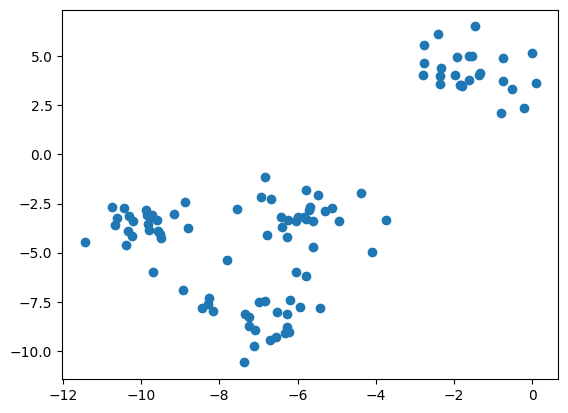

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
import dimod as dmd
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import random
import json

np.random.seed(1)
random.seed(1)


#X, y = make_blobs(n_samples=300, centers=5, n_features=2, random_state=13)
X, y = make_blobs(n_samples=100, centers=4, n_features=2, random_state=1)

plt.scatter(X[:,0], X[:,1])
plt.show()

Let's define some useful methods which will help us in this notebook.
The method ``` compute_corrloss``` computes, namely, the correntropy loss between all the data points in the dataset.

In [6]:
def compute_corrloss(data):
    """
    Computes the correntropy loss.

    Parameters:
    - data : The input data.

    Returns:
    - W : The correntropy loss.
    """
    D = distance.squareform(distance.pdist(data, metric='euclidean'))
    W = 1 - np.exp( - D / 2)

    return W

The following methods are necessary to transform the matrix Q representing the QUBO problem into the format needed by the Quantum Annealer. In particular, the matrix Q must be upper-triangular and must be passed to the QA as a dictionary with keys in the form ```(i,j)```.

In [7]:
def matrix_to_dict(M):
    """
    Converts a matrix to a QUBO dictionary.

    Parameters:
    - M : The input matrix.

    Returns:
    - q : The QUBO dictionary.
    """
    q = {}
    for i in range(0, len(M)):
        for j in range(i, len(M)):
            if M[i,j] != 0 :
                q[(i,j)] = M[i,j]
    return q

def to_upper_triangular(M):
    """
    Converts the matrix to upper triangular.

    Parameters:
    - M : The input matrix.

    Returns:
    - M2 + diagM : The upper triangular matrix.
    """
    diag = np.diag(M)
    diagM = np.diag(diag)

    M1 = M - diagM
    M2 = np.triu(M1)
    M2 *= 2

    return M2 + diagM

In the method ```quantum_medoids``` we finally compute the medoids of our cluster algorithm.
We compute here the QUBO matrix Q and solve the QUBO problem.

Notice that, in order to use the QA, we have to:
1. Transform Q into a dictionary dictQ (element ```[i,j]``` of Q ---> tuple ```(i,j)``` of dictQ)
2. Transform Q into a bqm (Binary Quadratic Problem, format defined by D-Wave)
3. Define a *sampler*, which in D-Wave's library defines a solver. Different samplers mean different algorithms. Here are some examples of [samplers implementing classical heuristical algorithms](https://docs.ocean.dwavesys.com/en/stable/docs_samplers/index.html), while for QA refer to [EmbeddingComposite and DWaveSampler](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html#embedding).

The reason why we use term *embedding* in QA is because of the need to embed the problem onto the QPU: in theory, to each qubit of the QPU should correspond a QUBO variable; in practice, it is not possible to guarantee this one-to-one relationship and a single QUBO variable is represented by multiple qubits which form a *chain*. The result is that QA could solve a problem with a totally different structure.


In [8]:
def quantum_medoids(data, n_clusters):
    """
    Quantum Medoids clustering algorithm.

    Parameters:
    - data : The input data.
    - n_clusters : The number of clusters to form.

    Returns:
    - medoids_index : The indices corresponding to the points that are chosen as cluster medoids.
    """
    N = len(data)
    alpha = 1/n_clusters
    beta = 1/N
    gamma = 2

    Q = np.zeros([N,N])

    delta = compute_corrloss(data)

    Q = gamma - alpha * delta / 2

    for i in range(N):
        Q[i,i] += beta * np.sum(delta[i]) - 2 * gamma * n_clusters


    Q = to_upper_triangular(Q)
    dictQ = matrix_to_dict(Q)

    bqm = dmd.binary.BinaryQuadraticModel.from_qubo(dictQ)

    sampler = SimulatedAnnealingSampler()
    sampleset=qa.submit(sampler, SimulatedAnnealingSampler.sample, bqm, num_reads=500, label="3 - Clustering example")

    solution = np.array(list(sampleset.first.sample.values()))
    medoids_index = np.where(solution == 1)[0]

    return medoids_index

In [9]:
def compute_clusters(X, medoids_index):
    """
    Quantum Medoids clustering algorithm.

    Parameters:
    - X : The input data.
    - medoids_index : The number of clusters to form.

    Returns:
    - closest_dict : The dictionary representing the medoids and their associated points.
    """
    # Dictionary to store closest points
    closest_dict = {}

    for x in X:
        min_distance=float('inf')
        associated_medoid_index=None
        for m in medoids_index:
            distance = np.linalg.norm(X[m] - x)
            if(distance<min_distance):
                associated_medoid_index=m
                min_distance=distance

        if(closest_dict.get(associated_medoid_index) is None):
            closest_dict[associated_medoid_index]=[]
        closest_dict[associated_medoid_index].append(x)

    return closest_dict


def plot_clusters(X,clusters):
    """
    Plots the achieved clusters.

    Parameters:
    - X : The input data.
    - clusters : The dictionary representing the clusters.
    """
    for medoid, points in clusters.items():
        plt.scatter(np.array(points)[:,0], np.array(points)[:,1], label=medoid)
        plt.scatter(X[medoid,0],X[medoid,1], color='black', marker='x', s=100)

    plt.title(f"Clusters and medoids for k={len(clusters.keys())}")
    plt.legend()
    plt.show()

def compute_silhouette_score(clusters):
    """
    Computes the silhouette score given a cluster dictionary.

    Parameters:
    - clusters : The dictionary representing the clusters.
    """
    all_points=[]
    all_labels=[]
    for cluster, points in clusters.items():
        all_points.extend(points)
        all_labels.extend([cluster] * len(points))

    silhouette = silhouette_score(all_points, all_labels)
    return silhouette

def plot_silhouette(silhouettes):
    """
    Plots the silhouette coefficients according to the number of clusters.

    Parameters:
    - silhouettes : The dictionary of silhouette coefficients having as keys the numbers of clusters.
    """
    x=[]
    y=[]
    for k,v in silhouettes.items():
        x.append(k)
        y.append(v)

    plt.plot(x, y,marker='o', linestyle='-')
    plt.title("Silhouette Coefficient based on the number of clusters")
    plt.show()


In [10]:
silhouettes_quantum={}

for k in range(3, 7):
    medoids_index = quantum_medoids(X, k)
    medoids = X[medoids_index]
    clusters=compute_clusters(X, medoids_index)
    plot_clusters(X,clusters)

    silhouettes_quantum[k]=compute_silhouette_score(clusters)

plot_silhouette(silhouettes_quantum)

NameError: name 'qa' is not defined

## Comparison with classical k-medoids

In [92]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00


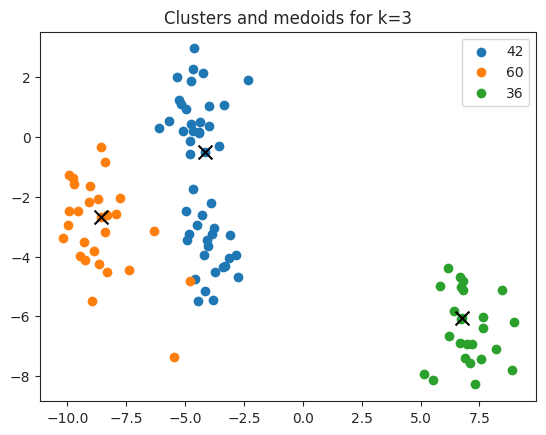

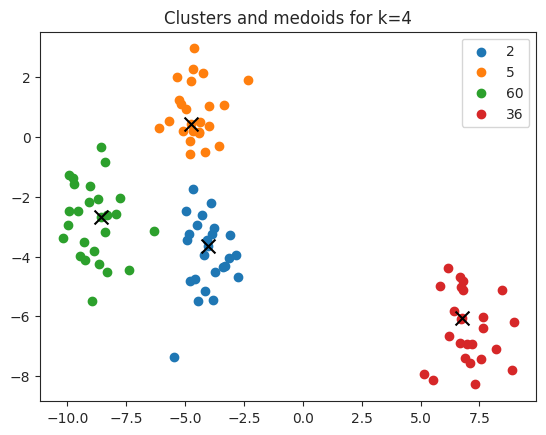

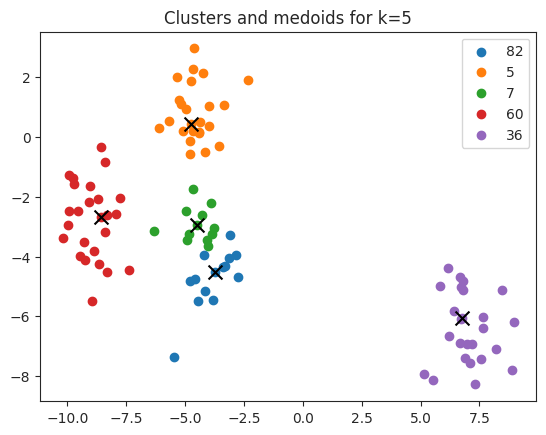

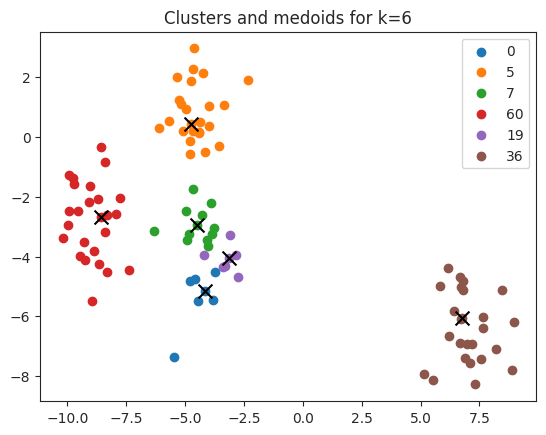

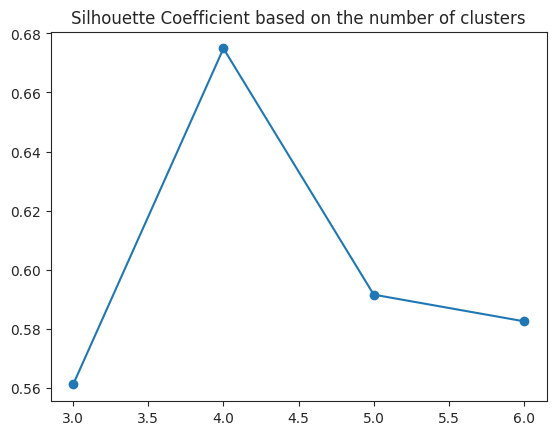

In [96]:
from sklearn_extra.cluster import KMedoids
import numpy as np

silhouettes_classical={}

for k in range(3, 7):
    kmedoids = KMedoids(n_clusters=k, random_state=0).fit(X)
    medoids_index = kmedoids.medoid_indices_
    medoids = X[medoids_index]
    clusters=compute_clusters(X, medoids_index)
    plot_clusters(X,clusters)

    silhouettes_classical[k]=compute_silhouette_score(clusters)

plot_silhouette(silhouettes_classical)

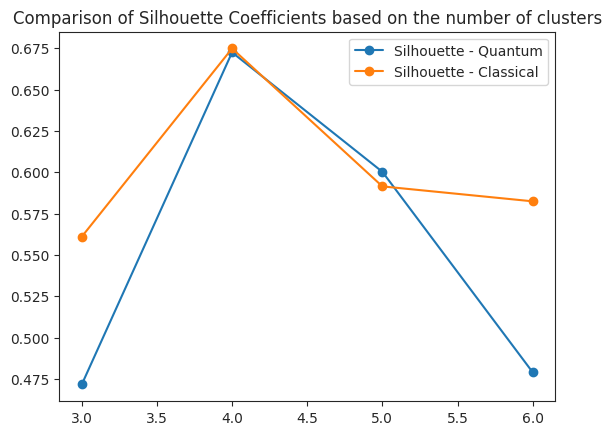

In [106]:
def plot_silhouettes(silhouettes_quantum, silhouettes_classical):
    x=[]
    y=[]
    for k,v in silhouettes_quantum.items():
        x.append(k)
        y.append(v)

    plt.plot(x, y,marker='o', linestyle='-', label="Silhouette - Quantum")

    x=[]
    y=[]
    for k,v in silhouettes_classical.items():
        x.append(k)
        y.append(v)

    plt.plot(x, y,marker='o', linestyle='-', label="Silhouette - Classical")
    plt.title("Comparison of Silhouette Coefficients based on the number of clusters")
    plt.legend()
    plt.show()

plot_silhouettes(silhouettes_quantum,silhouettes_classical)

Now I try to "find" the proper number k of cluster through validation via Silhouette Coefficient

## How a real submission works


In [130]:
class DataPoint:
    def __init__(self, id, coordinates, center):
        self.id=id
        self.coordinates=coordinates
        self.center=center


def quantum_medoids_datapoints(data, n_clusters):

    N = len(data)
    alpha = 1/n_clusters
    beta = 1/N
    gamma = 2

    Q = np.zeros([N,N])

    points_array=[]
    for p in data:
        points_array.append(p.coordinates)
    points_array=np.array(points_array)

    delta = compute_corrloss(points_array)

    Q = gamma - alpha * delta / 2

    for i in range(N):
        Q[i,i] += beta * np.sum(delta[i]) - 2 * gamma * n_clusters

    Q = to_upper_triangular(Q)
    dictQ = matrix_to_dict(Q)

    bqm = dmd.binary.BinaryQuadraticModel.from_qubo(dictQ)

    sampler = SimulatedAnnealingSampler()
    sampleset=qa.submit(sampler, SimulatedAnnealingSampler.sample, bqm, num_reads=500, label="3 - Clustering example")

    solution = np.array(list(sampleset.first.sample.values()))
    medoids_index = np.where(solution == 1)[0]
    medoids_ids=[]
    for i,p in enumerate(data):
        if i in medoids_index:
            medoids_ids.append(p.id)

    return medoids_ids

def get_point_by_id(X,id):
    for p in X:
        if(p.id==id):
            return p
    return None

def compute_clusters_datapoints(X, medoids_ids):
    # Dictionary to store closest points
    closest_dict = {}

    for x in X:
        min_distance=float('inf')

        associated_medoid_id=None
        for m in medoids_ids:

            medoid=get_point_by_id(X,m)
            distance = np.linalg.norm(medoid.coordinates - x.coordinates)
            if(distance<min_distance):
                associated_medoid_id=m
                min_distance=distance

        if(closest_dict.get(associated_medoid_id) is None):
            closest_dict[associated_medoid_id]=[]
        closest_dict[associated_medoid_id].append(x)

    return closest_dict


def plot_clusters(X,clusters):
    for medoid, points in clusters.items():
        plt.scatter(np.array(points)[:,0], np.array(points)[:,1], label=medoid)
        plt.scatter(X[medoid,0],X[medoid,1], color='black', marker='x', s=100)

    plt.title(f"Clusters and medoids for k={len(clusters.keys())}")
    plt.legend()
    plt.show()


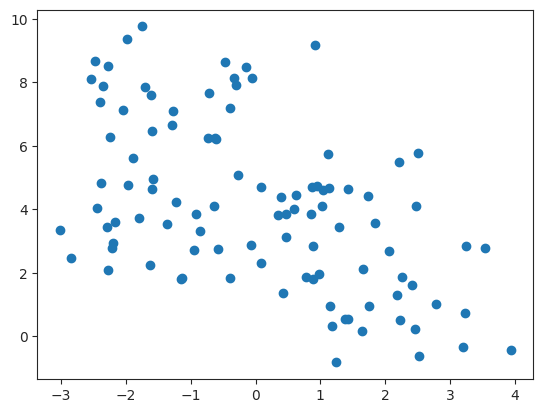

[8, 61]


In [ ]:
filename="./submissions/clustering.txt"

X, y = make_blobs(n_samples=100, centers=4, n_features=2, random_state=0)

plt.scatter(X[:,0], X[:,1])
plt.show()

datapoints=[]
for i,x in enumerate(X):
    datapoints.append(DataPoint(i,x,None))

medoids_ids=quantum_medoids_datapoints(datapoints,2)
print(medoids_ids)

cluster=compute_clusters_datapoints(datapoints, medoids_ids)


submission=[]
for medoid_id, clustered_points in cluster.items():
    cluster_data={}
    cluster_data['centroid']=get_point_by_id(datapoints,medoid_id).coordinates.tolist()
    cluster_data['docs']=[]
    for p in clustered_points:
        cluster_data['docs'].append(p.id)
    submission.append(cluster_data)

submission_text= json.dumps(submission)

with open(filename, 'w') as file:
    file.write(submission_text)
    
# Please, remember to also include the list of problem ids that you solved to obtain the final solution.
# The ids can be retrieved for each problem in the following way:
ids=[response.info['problem_id']] # The ids can be retrieved also from your dashboard. These should be reported in the last line of your submission file as a list of ids.
